In [1]:
from matplotlib import colors as plt_colors # For color conversions
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

## Import du fichier Excel traité manuellement :

In [2]:
df_from_excel = pd.read_excel(
    'Data/inputs/20240531_df_results.xlsx',
    usecols=[
        'NCTId',
        'pmid',
        'type_de_publication',
        'commentaire',
    ],
)
df_from_excel = df_from_excel.astype(
    {
        'pmid': 'Int64',
        'type_de_publication': 'category',
    }
)

C:\Users\julien.bacquart\Development\BSO-Inserm-Sante\venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
df_from_excel

,NCTId,pmid,type_de_publication,commentaire
0,NCT02592174,31755936,publication,NaN
1,NCT02273765,33667406,publication,NaN
2,NCT05311865,36438274,protocole,NaN
3,NCT05311865,37795682,publication,NaN
4,NCT02107365,<NA>,NaN,NaN
...,...,...,...,...
495,NCT02481453,20413309,background,NaN
496,NCT02481453,24975859,background,NaN
497,NCT02481453,38273639,résultat négatif,NaN
498,NCT02658253,33717176,publication,NaN


In [4]:
df_from_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   NCTId                500 non-null    object  
 1   pmid                 394 non-null    Int64   
 2   type_de_publication  394 non-null    category
 3   commentaire          10 non-null     object  
dtypes: Int64(1), category(1), object(2)
memory usage: 13.0+ KB


#### type_de_publication :

In [5]:
df_from_excel.loc[:, 'type_de_publication'].value_counts()

type_de_publication
publication         233
background          113
protocole            19
résultat négatif     17
autre                 7
méta-analyse          5
Name: count, dtype: int64

## Import de la DataFrame :

In [6]:
df_corrected = pd.read_csv('Data/outputs/df_corrected.csv', sep=';', encoding='utf-8-sig')

In [7]:
df_corrected = df_corrected.astype(
    {
        # ClinicalTrial
        'OverallStatus': 'category',
        'StudyType': 'category',
        'type': 'category',

        'pmid': 'Int64',

        'StudyFirstPostDate': 'datetime64[ns]',
        'StartDate': 'datetime64[ns]',
        'CompletionDate': 'datetime64[ns]',

        # Unpaywall
        'is_paratext': 'boolean',
        'published_date': 'datetime64[ns]',
        'is_oa': 'boolean',
        'oa_status': 'category',
        'has_repository_copy': 'boolean',

        # OpenAlex
        'type_openalex': 'category',
        'primary_topic': 'category',
        'subfield': 'category',
        'field': 'category',
        'domain': 'category',
    }
)  # fmt: skip
# df_corrected = df_extract.convert_dtypes()
df_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   NCTId                500 non-null    object        
 1   BriefTitle           500 non-null    object        
 2   LeadSponsorName      500 non-null    object        
 3   CollaboratorName     225 non-null    object        
 4   OverallStatus        500 non-null    category      
 5   StudyType            500 non-null    category      
 6   HasResults           500 non-null    bool          
 7   StudyFirstPostDate   500 non-null    datetime64[ns]
 8   StartDate            500 non-null    datetime64[ns]
 9   CompletionDate       500 non-null    datetime64[ns]
 10  pmid                 394 non-null    Int64         
 11  type                 394 non-null    category      
 12  title                394 non-null    object        
 13  authors              394 non-null  

On incorpore les données du traitement manuel dans notre dataframe  :

In [8]:
df_complete = df_corrected.merge(
    df_from_excel.loc[:, ['NCTId', 'pmid', 'type_de_publication']],
    on=['NCTId', 'pmid'],
    how='left',
    validate='one_to_one',
)

In [9]:
df_complete.loc[:, ['NCTId', 'pmid', 'type', 'type_de_publication']]

,NCTId,pmid,type,type_de_publication
0,NCT02592174,31755936,DERIVED,publication
1,NCT02273765,33667406,DERIVED,publication
2,NCT05311865,36438274,PUBMED,protocole
3,NCT05311865,37795682,PUBMED,publication
4,NCT02107365,<NA>,NaN,NaN
...,...,...,...,...
495,NCT02481453,20413309,BACKGROUND,background
496,NCT02481453,24975859,BACKGROUND,background
497,NCT02481453,38273639,PUBMED,résultat négatif
498,NCT02658253,33717176,DERIVED,publication


Pour chaque étude clinique, on cherche à savoir si elle a donné lieu a la publication d'un résultat.  
Donc pour chaque 'type_de_publication' issu du traitement manuel, on le répartit dans l'une des deux catégories :

- Résultat :
    + publication
    + résultat négatif
    + méta-analyse
- Non Résultat:
    + background
    + protocole
    + autre (commentaire, lettre, erratum...)


In [10]:
mask_is_result = df_complete.loc[:, 'type_de_publication'].isin(['publication', 'résultat négatif', 'méta-analyse'])
df_complete.loc[mask_is_result, 'is_result'] = True

mask_not_result = df_complete.loc[:, 'type_de_publication'].isin(['background', 'protocole', 'autre'])
df_complete.loc[mask_not_result, 'is_result'] = False

df_complete['is_result'] = df_complete['is_result'].astype('boolean')

In [11]:
df_complete.loc[:, ['NCTId', 'type_de_publication', 'is_result']]

,NCTId,type_de_publication,is_result
0,NCT02592174,publication,True
1,NCT02273765,publication,True
2,NCT05311865,protocole,False
3,NCT05311865,publication,True
4,NCT02107365,NaN,<NA>
...,...,...,...
495,NCT02481453,background,False
496,NCT02481453,background,False
497,NCT02481453,résultat négatif,True
498,NCT02658253,publication,True


In [12]:
df_complete.loc[:, 'is_result'].value_counts(dropna=False)

is_result
True     255
False    139
<NA>     106
Name: count, dtype: Int64

## Correlation entre le 'type' ClinicalTrial et le 'type' du traitement manuel :

On cherche a comparer la correlation des types renvoyés par ClinicalTrial ('RESULT', 'BACKGROUND', ...) et les types déterminés à l'issu du traitement manuel ('publication', 'background' ...).  
Est-ce que les résultats concordent ?  
Si la correlation est très forte, peut-on se passer du traitement manuel et faire uniquement confiance aux types renvoyés par CT ? 

In [13]:
count_type_ct = df_complete.loc[:, 'type'].value_counts()
count_type_ct

type
DERIVED       142
BACKGROUND    110
RESULT         89
PUBMED         31
SUSPICIOUS     22
Name: count, dtype: int64

In [14]:
count_type_manual = df_complete.loc[:, 'type_de_publication'].value_counts()
count_type_manual

type_de_publication
publication         233
background          113
protocole            19
résultat négatif     17
autre                 7
méta-analyse          5
Name: count, dtype: int64

In [15]:
df_complete.loc[:, ['type','type_de_publication']]

,type,type_de_publication
0,DERIVED,publication
1,DERIVED,publication
2,PUBMED,protocole
3,PUBMED,publication
4,NaN,NaN
...,...,...
495,BACKGROUND,background
496,BACKGROUND,background
497,PUBMED,résultat négatif
498,DERIVED,publication


### Pivot tables :

In [16]:
df_correlation = pd.pivot_table(
    df_complete,
    index='type',
    columns='type_de_publication',
    aggfunc='size',
    observed=False,
)

index_order = count_type_ct.index.values
column_order = count_type_manual.index.values
df_correlation = df_correlation.reindex(index=index_order, columns=column_order)
df_correlation

type_de_publication,publication,background,protocole,résultat négatif,autre,méta-analyse
type,,,,,,
DERIVED,110,1,12,14,2,3
BACKGROUND,13,88,6,0,2,1
RESULT,82,3,0,1,3,0
PUBMED,27,0,1,2,0,1
SUSPICIOUS,1,21,0,0,0,0


In [17]:
df_correlation_perc = pd.crosstab(
    index=df_corrected.loc[:,'type'],
    columns=df_complete.loc[:,'type_de_publication'],
    normalize= 'index',
    # aggfunc='size',
    # fill_value=0,
    # observed=False,
)
df_correlation_perc = df_correlation_perc.reindex(index=index_order, columns=column_order)
df_correlation_perc

type_de_publication,publication,background,protocole,résultat négatif,autre,méta-analyse
type,,,,,,
DERIVED,0.774648,0.007042,0.084507,0.098592,0.014085,0.021127
BACKGROUND,0.118182,0.800000,0.054545,0.000000,0.018182,0.009091
RESULT,0.921348,0.033708,0.000000,0.011236,0.033708,0.000000
PUBMED,0.870968,0.000000,0.032258,0.064516,0.000000,0.032258
SUSPICIOUS,0.045455,0.954545,0.000000,0.000000,0.000000,0.000000


### Heatmaps :

#### Effectifs :

<Axes: xlabel='type_de_publication', ylabel='type'>

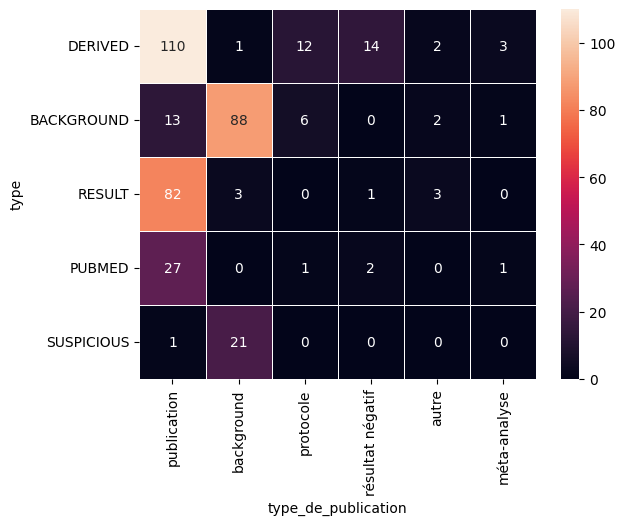

In [18]:
sns.heatmap(
    df_correlation, 
    annot =True,
    linewidth=.4,
    fmt='d'
)

#### Pourcentages :

<Axes: xlabel='type_de_publication', ylabel='type'>

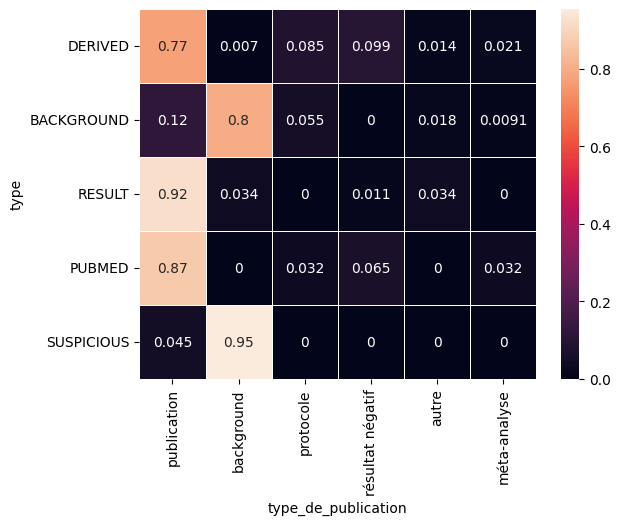

In [19]:
sns.heatmap(
    df_correlation_perc, 
    annot=True,
    linewidth=.4,
)

Les 'types' où la correlation est la plus faible sont malheuresement les types où l'effectif est le plus important.

## Correlation entre le 'type' ClinicalTrial et 'is_result' du traitement manuel :

In [20]:
df_complete.loc[:, ['type','is_result']]

,type,is_result
0,DERIVED,True
1,DERIVED,True
2,PUBMED,False
3,PUBMED,True
4,NaN,<NA>
...,...,...
495,BACKGROUND,False
496,BACKGROUND,False
497,PUBMED,True
498,DERIVED,True


### Pivot tables :

In [21]:
df_correlation_result = pd.pivot_table(
    df_complete,
    index='type',
    columns='is_result',
    aggfunc='size',
    observed=False,
)
df_correlation_result

is_result,False,True
type,,
BACKGROUND,96,14
DERIVED,15,127
PUBMED,1,30
RESULT,6,83
SUSPICIOUS,21,1


In [22]:
df_correlation_result_perc = pd.crosstab(
    index=df_corrected.loc[:,'type'], 
    columns=df_complete.loc[:, 'is_result'],
    normalize='index',
    # aggfunc='size',
    # fill_value=0,
    # observed=False,
)
df_correlation_result_perc

is_result,False,True
type,,
BACKGROUND,0.872727,0.127273
DERIVED,0.105634,0.894366
PUBMED,0.032258,0.967742
RESULT,0.067416,0.932584
SUSPICIOUS,0.954545,0.045455


### Heatmaps :

#### Effectifs :

<Axes: xlabel='is_result', ylabel='type'>

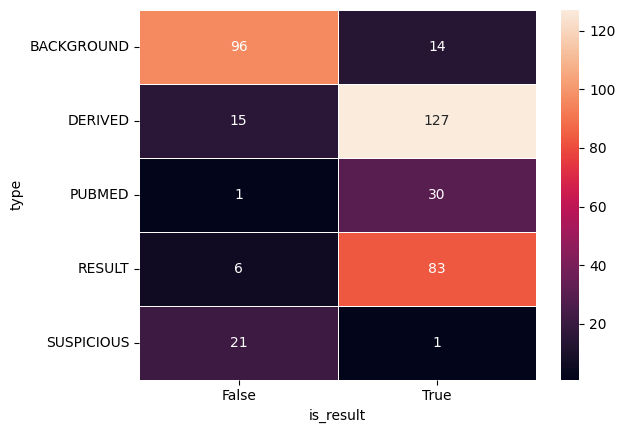

In [23]:
sns.heatmap(
    df_correlation_result, 
    annot=True,
    linewidth=.4,
    fmt='d'
)

#### Pourcentages :

<Axes: xlabel='is_result', ylabel='type'>

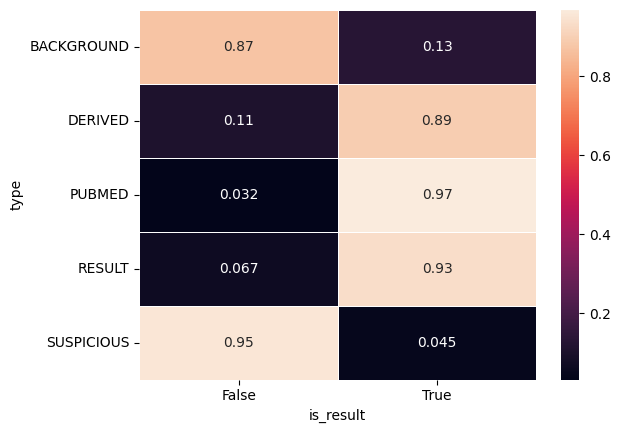

In [24]:
sns.heatmap(
    df_correlation_result_perc, 
    annot=True,
    linewidth=.4,
)

Les 'types' où la correlation est la plus faible sont malheuresement les types où l'effectif est le plus important.

## Sankey Diagram :

In [143]:
type_ct_list = list(count_type_ct.index.values)
type_manual_list = list(count_type_manual.index.values)
labels = (
    ['Ensemble des publications']
    + type_ct_list
    + type_manual_list
    + ['Résultat', 'Non résultat']
)

In [141]:
# Associate a number to each label, so we can indicate the links between nodes in the Sankey diagram,
# 0 -> 1, 0 -> 2, etc. 
# Kind of a dirty Enum
# {'Ensemble ...': 0, 'DERIVED': 1, 'BACKGROUND': 2, ...}
d = {t : i for i, t in enumerate(labels)}
d

{'Ensemble des publications': 0,
 'DERIVED': 1,
 'BACKGROUND': 2,
 'RESULT': 3,
 'PUBMED': 4,
 'SUSPICIOUS': 5,
 'publication': 6,
 'background': 7,
 'protocole': 8,
 'résultat négatif': 9,
 'autre': 10,
 'méta-analyse': 11,
 'Résultat': 12,
 'Non résultat': 13}

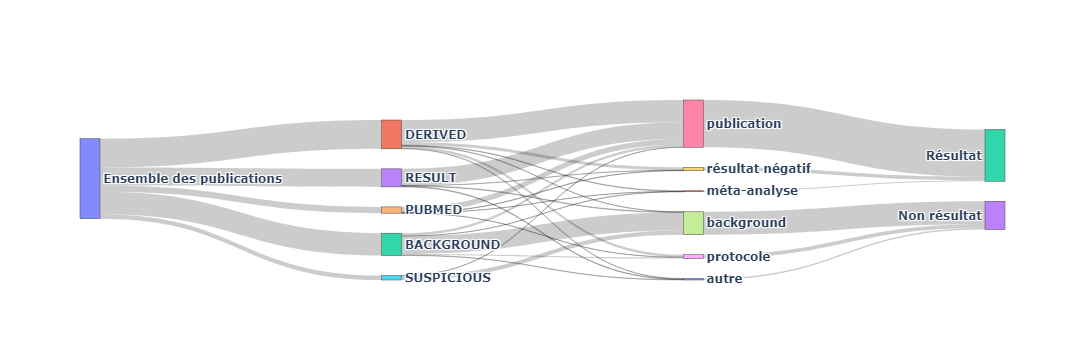

In [145]:
import itertools

# First level:
# From all publications to ClinicalTrial types:
source_all = [d['Ensemble des publications']] * len(type_ct_list)
target_type_ct = [d[t] for t in type_ct_list]
value_type_ct = [count_type_ct.loc[t] for t in type_ct_list]

## Second level:
# From ClinicalTrial types to manually processed types:
# [1,1,1,1,1,1,2,2,...]
source_type_ct = list(
    itertools.chain.from_iterable(
        [[d[t]] * len(type_manual_list) for t in type_ct_list]
    )
)
# [6,7,8,9,10,11,6,7,...]
source_type_ct = list(
    itertools.chain.from_iterable(
        [[d[t]] * len(type_manual_list) for t in type_ct_list]
    )
)
# Cartesian product of all CT types with all manual processed types
value_type_manual = [
    df_correlation.loc[t, t_d_p]
    for t, t_d_p in itertools.product(type_ct_list, type_manual_list)
]

### Third level:
# From manually processed types to is_result:
source_manual = [d[t] for t in type_manual_list]
target_is_result = [
    d['Résultat']
    if t in ['publication', 'résultat négatif', 'méta-analyse']
    else d['Non résultat']
    for t in type_manual_list
]
value_is_result = [count_type_manual.loc[t] for t in type_manual_list]

# Put together
source = source_all + source_type_ct + source_manual
target = target_type_ct + target_type_manual + target_is_result
value = value_type_ct + value_type_manual + value_is_result

# colors = ["cornflowerblue", "tomato", "mediumseagreen", "#4CAF50", "gold"]
# TODO: Add percents
# percentages = [f"{(value[t-1]/num_trials):.2%}" for t in target]

# TODO: Add color transparency
# Add transparency to the list of colors, to display links with partial opacity
# transparency = 0.5
# colors_transparency = [
#     f'rgba({rgba_color[0] * 255:.0f}, {rgba_color[1] * 255:.0f}, {rgba_color[2] * 255:.0f}, {rgba_color[3]})'
#     for color in colors
#     if (rgba_color := plt_colors.to_rgba(color, transparency))
# ]

fig = go.Figure(
    data=[
        go.Sankey(
            valuesuffix=' publications',
            valueformat='d',
            # Nodes
            node=dict(
                label=[f'<b>{label}</b>' for label in labels],
                # line = dict(color = "black", width = 0.),
                hovertemplate='%{label}:',
            ),
            # Links
            link=dict(
                # arrowlen=15,
                source=source,
                target=target,
                value=value,
                # customdata=percentages,
                # hovertemplate = "%{label}%{value}<extra>%{customdata}</extra>",
                hovertemplate='%{source.label} > %{target.label}',
                hoverlabel=dict(bgcolor='#444'),
                # color = colors_transparency[1:],
                # hovercolor = colors[1:],
            ),
        )
    ]
)

# fig.update_layout(title_text='Basic Sankey Diagram', font_size=10)
fig.show()

## Date de fin d'étude antérieure à 2023 :

Les essais terminés doivent normalement faire l'objet d’un dépôt des résultats de ces essais, dans les 12 mois au plus tard après
la date de la fin d’étude et d’une publication dans les journaux.  
Pour des données récoltées en 2024, on va donc se limiter aux essais terminés en 2022 et qui ont pu faire l'objet de publications en 2023.

<span style="color:red">**Mettre à jour la date si nécessaire**</span>

In [44]:
mask_date = df_complete['CompletionDate'].dt.year < 2023
# df_complete.loc[mask_date, 'CompletionDate']

In [45]:
df_complete_date = df_complete.loc[mask_date]
# df_complete_date

#### Nombre d'études cliniques:

In [46]:
num_trials = len(df_complete_date.loc[:, 'NCTId'].unique())
num_trials

190

#### Nombre de publications :

In [47]:
num_publications = df_complete_date.loc[:, 'pmid'].notna().sum()
num_publications

368

#### Nombre d'études sans publications :

In [48]:
num_trials_wo_pub = len(df_complete_date.loc[df_complete_date.loc[:, 'pmid'].isna(), 'NCTId'])
print("Nombre d'études sans publications:")
print(f'{num_trials_wo_pub} / {num_trials} ({num_trials_wo_pub / num_trials:.2%})')

Nombre d'études sans publications:
99 / 190 (52.11%)


#### Nombre d'études avec publications :

In [49]:
num_trials_with_pub = len(
    df_complete_date.loc[df_complete_date.loc[:, 'pmid'].notna(), 'NCTId'].unique()
)
print("Nombre d'études avec au moins une publication :")
print(f'{num_trials_with_pub} / {num_trials} ({num_trials_with_pub / num_trials:.2%})')

Nombre d'études avec au moins une publication :
91 / 190 (47.89%)


#### Nombre d'études avec au moins une publication de type 'Résultat' :

In [50]:
# 'is_result' == True
mask_is_result = df_complete_date.loc[:, 'is_result']
num_trials_with_result = len(df_complete_date.loc[mask_is_result, 'NCTId'].unique())

print("Nombre d'études avec au moins une publication de type 'Résultat' :")
print(f'{num_trials_with_result} / {num_trials} ({num_trials_with_result / num_trials:.2%})')

Nombre d'études avec au moins une publication de type 'Résultat' :
78 / 190 (41.05%)


#### Nombre d'études avec des publications, mais aucune de type 'Résultat' :

In [51]:
nctids = df_complete_date.loc[:, 'NCTId'].unique()

# NCTIDs with publications, but none of their publications are of type result
# (eq. for which all 'is_result' are False)
res = []
for nctid in nctids:
    mask = df_complete_date.loc[:, 'NCTId'] == nctid
    
    # 'is_result' is not <NA> and all the values of 'is_result' are False
    if (not df_complete_date.loc[mask, 'is_result'].dropna().empty and (~(df_complete_date.loc[mask, 'is_result'])).all()):
        res.append(nctid)

num_trials_wo_any_result = len(res)
# df_complete_date.loc[df_complete_date.loc[:, 'NCTId'].isin(res), ['NCTId', 'type_de_publication', 'is_result']]

print("Nombre d'études avec des publications, mais aucune de type 'Résultat :")
print(f'{num_trials_wo_any_result} / {num_trials} ({num_trials_wo_any_result / num_trials:.2%})')

Nombre d'études avec des publications, mais aucune de type 'Résultat :
13 / 190 (6.84%)


#### Etudes :

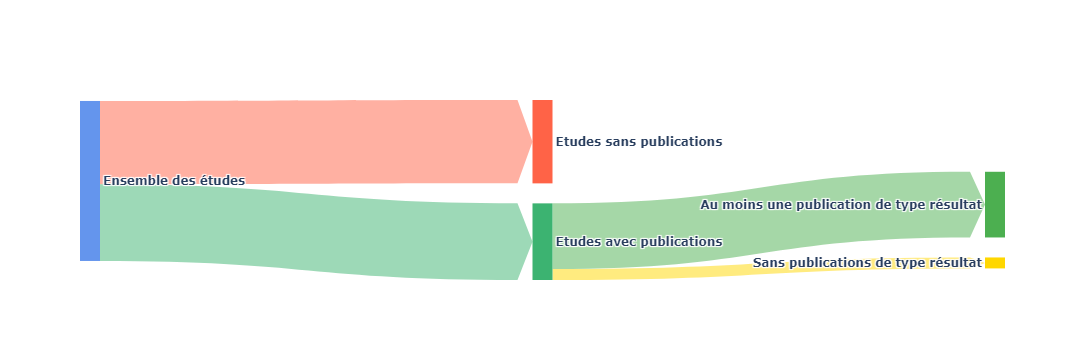

In [52]:
labels=["Ensemble des études", "Etudes sans publications", "Etudes avec publications", "Au moins une publication de type résultat", "Sans publications de type résultat"]
source=[0, 0, 2, 2,]
target=[1, 2, 3, 4,]
value=[num_trials_wo_pub, num_trials_with_pub, num_trials_with_result, num_trials_wo_any_result]
colors = ["cornflowerblue", "tomato", "mediumseagreen", "#4CAF50", "gold"]
percentages = [f"{(value[t-1]/num_trials):.2%}" for t in target]

# Add transparency to the list of colors, to display links with partial opacity
transparency = 0.5
colors_transparency = [
    f'rgba({rgba_color[0] * 255:.0f}, {rgba_color[1] * 255:.0f}, {rgba_color[2] * 255:.0f}, {rgba_color[3]})'
    for color in colors
    if (rgba_color := plt_colors.to_rgba(color, transparency))
]

fig = go.Figure(
    data=[
        go.Sankey(
            valuesuffix = " études",
            valueformat = "d",
            
            # Nodes
            node=dict(
                # label=label,
                label = [f"<b>{label}</b>" for label in labels],
                color = colors,
                line = dict(color = "black", width = 0.),
                align = "left",
                hovertemplate='%{label}:',
                # hoverlabel = dict(bgcolor = "#FFFFFF"), # white background
            ),
            
            # Links
            link=dict(
                arrowlen=15,
                source=source,
                target=target,
                value=value,
                customdata=percentages,
                hovertemplate = "%{label}%{value}<extra>%{customdata}</extra>",
                hoverlabel = dict(bgcolor ='#444'),
                color = colors_transparency[1:],
                hovercolor = colors[1:],
            ),
        )
    ]
)

# fig.update_layout(title_text='Basic Sankey Diagram', font_size=10)
fig.show()

In [56]:
df_complete_date.drop_duplicates(subset=['NCTId']).loc[:, 'StudyType'].value_counts()

StudyType
INTERVENTIONAL    130
OBSERVATIONAL      60
Name: count, dtype: int64

In [57]:
df_complete_date.loc[~df_complete_date.loc[:, 'NCTId'].duplicated(), 'StudyType'].value_counts()

StudyType
INTERVENTIONAL    130
OBSERVATIONAL      60
Name: count, dtype: int64

In [58]:
df_complete_date.loc[:, 'is_oa'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

is_oa
True     66.76%
False    33.24%
Name: proportion, dtype: object

In [59]:
df_complete_date.loc[df_complete['is_result'], 'is_oa'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

is_oa
True     67.8%
False    32.2%
Name: proportion, dtype: object

In [60]:
mask = df_complete.loc[:, 'NCTId'] == 'NCT00640263'
df_complete.loc[mask, ['NCTId', 'BriefTitle', 'pmid', 'title', 'type', 'type_de_publication']]

,NCTId,BriefTitle,pmid,title,type,type_de_publication
32,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,17825642,Prevention of human immunodeficiency virus-1 t...,BACKGROUND,background
33,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,32991450,Antiretroviral treatment and its impact on ora...,DERIVED,publication
34,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,23039034,Lopinavir/Ritonavir versus Lamivudine peri-exp...,DERIVED,protocole
35,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,32067040,Clinical and Biological Factors Associated Wit...,DERIVED,publication
36,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,31994250,Association of maternal HIV-1 severity with de...,DERIVED,publication
37,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,30814028,Growth in HIV-1-exposed but uninfected infants...,DERIVED,publication
38,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,26603917,Extended pre-exposure prophylaxis with lopinav...,DERIVED,publication
39,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,28469697,Breastfeeding patterns and its determinants am...,DERIVED,publication
40,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,31633158,Lopinavir-Ritonavir Impairs Adrenal Function i...,DERIVED,publication
41,NCT00640263,Comparison of Efficacy and Safety of Infant Pe...,32228542,Caries experience and oral health related qual...,DERIVED,publication


In [61]:
df_from_excel.loc[:, ['NCTId', 'pmid', 'type de publi']]

KeyError: "['type de publi'] not in index"

In [ ]:
df_from_excel.loc[:, 'type de publi'].value_counts()

In [ ]:
df_tmp = pd.read_excel(
    'Data/outputs/df_for_manual_treatment.xlsx',
    usecols=[
        'NCTId',
        'BriefTitle',
        'HasResults',
        'pmid',
        'doi',
    ],
)
df_tmp

In [ ]:
df_to_copy = df_tmp.merge(
    df_from_excel.loc[:, ['NCTId', 'pmid', 'type de publi']],
    on=['NCTId', 'pmid'],
    how='left',
    validate='one_to_one',
)
df_to_copy

In [ ]:
df_to_copy.loc[:, 'type de publi'].value_counts()

In [ ]:
df_to_copy.to_csv(
    'Data/outputs/df_to_copy.csv',
    # columns=columns_to_export,
    sep=';',
    index=False,
    encoding='utf-8-sig',
)